In [1]:
#import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
import keras
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras.initializers import RandomNormal, Constant
from mixup_generator import MixupImageDataGenerator

In [2]:
# open saved image and label dataframe
df = pd.read_csv('../Datasets/labels.csv')
# df.drop(columns=['Unnamed: 0'],inplace=True)

In [3]:
# split train:validation:test = 8.5:1:1
train_img, valid_img = train_test_split(df, test_size = 0.15,random_state=42)
valid_img, test_img = train_test_split(valid_img, test_size = 0.5,random_state=24)
#train_img.to_csv('train_img.csv')
#valid_img.to_csv('valid_img.csv')
#test_img.to_csv('test_img.csv')

In [4]:
# open training dataset and validation dataset 
# train_img=pd.read_csv('train_img.csv')
# valid_img=pd.read_csv('valid_img.csv')
# train_img.drop(columns=['Unnamed: 0'],inplace=True)
# valid_img.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
#set training parameters
IMAGE_SIZE = 220
BATCH_SIZE = 12

In [6]:
# configure image generator
img_gen = ImageDataGenerator(rescale = 1.0/255.0, horizontal_flip = True, vertical_flip   = True,
                               fill_mode = 'nearest', rotation_range = 10, width_shift_range = 0.2,
                               height_shift_range= 0.2, shear_range= 0.2, brightness_range= (0.5,1.2),
                               zoom_range = 0.2)
train = MixupImageDataGenerator(train_img, generator=img_gen,directory='../Datasets/train',x_col = 'filename', y_col = 'label',
                                batch_size=BATCH_SIZE,target_size =(IMAGE_SIZE, IMAGE_SIZE))
val = img_gen.flow_from_dataframe(valid_img, directory = '../Datasets/train',x_col = 'filename', y_col = 'label', 
                                  target_size =(IMAGE_SIZE, IMAGE_SIZE), class_mode = 'categorical',
                                  batch_size = BATCH_SIZE, color_mode = 'rgb', shuffle = True)

Found 4807 validated image filenames belonging to 5 classes.
Found 4807 validated image filenames belonging to 5 classes.
Found 424 validated image filenames belonging to 5 classes.


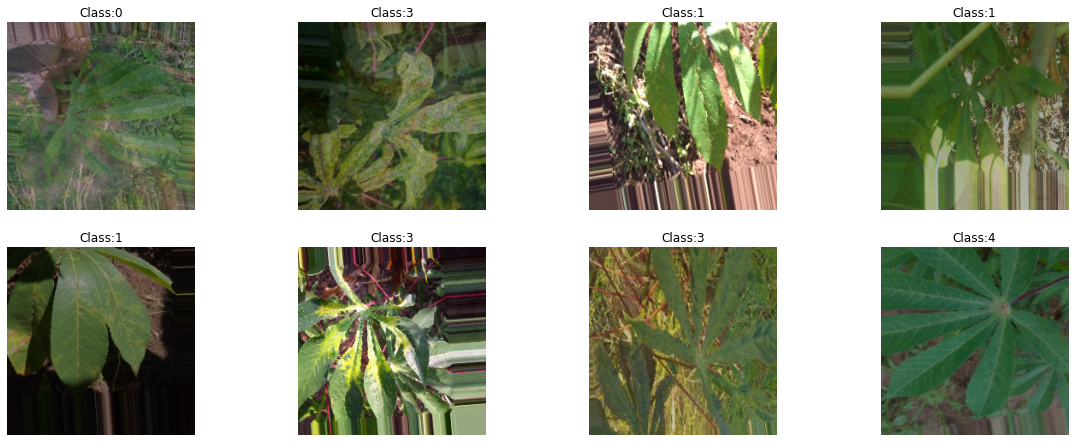

In [7]:
# visualize sample images generated by image generator
samples = 8
plt.figure(figsize=(20,20))
for x_gens, y_gens in train:
    i = 0
    for sample_img, sample_class in zip(x_gens, y_gens):
        plt.subplot(5,4,i+1)
        plt.title(f'Class:{np.argmax(sample_class)}')
        plt.axis('off')
        plt.imshow(sample_img)
        i += 1
        if i >= samples:
            break
    break

In [8]:
print("GPU number: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPU number:  1


In [9]:
def create_model():
    # build neural network: efficientNet B3 + Batch Normalization + regularization + MixUp
    model = Sequential()
    model.add(EfficientNetB3(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, 
                             weights='imagenet', drop_connect_rate=0.25))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    BatchNormalization(momentum=0.95, epsilon=0.005,beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                       gamma_initializer=Constant(value=0.5))    
    model.add(Dense(256, activation='relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.25))
    BatchNormalization(momentum=0.95, epsilon=0.005,beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                       gamma_initializer=Constant(value=0.5))
    model.add(Dense(5, activation = 'softmax'))
    
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non-trainable params: 87,303
_______________________________________

In [10]:
#set training parameters
EPOCHS = 50
STEP_TRAIN = train.n // train.batch_size
STEP_TEST = val.n // val.batch_size

In [11]:
def model_fit():
    # implement training helpers, early stopping and LR monitor, use Adam as optimizer
    model = create_model()
    # smooth labels to reduce overfit
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,label_smoothing=1e-3,name='categorical_crossentropy')
    # initialize learning rate  
    model.compile(optimizer = Adam(learning_rate = 1e-3), loss = loss, metrics = ['categorical_accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)
    # store best model
    checkpoint = ModelCheckpoint("efficientNetMixUp_best.h5",save_best_only=True,monitor='val_loss',mode='min')
    # reduce LR by 0.2 
    lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,min_lr=1e-10,patience=2,mode='min',verbose=1)
    history = model.fit(train,validation_data=val,epochs=EPOCHS,batch_size=BATCH_SIZE,
                             steps_per_epoch=STEP_TRAIN, validation_steps=STEP_TEST,
                              callbacks=[checkpoint, lr])
    return history

In [12]:
# start training
with tf.device('/GPU:0'):
    results = model_fit()
print('Train Categorical Accuracy: ', max(results.history['categorical_accuracy']))
print('Test Categorical Accuracy: ', max(results.history['val_categorical_accuracy']))

Epoch 1/50
400/400 [==============================] - 251s 568ms/step - loss: 1.2190 - categorical_accuracy: 0.5624 - val_loss: 2.3453 - val_categorical_accuracy: 0.0429
Epoch 2/50
400/400 [==============================] - 224s 560ms/step - loss: 0.9371 - categorical_accuracy: 0.6880 - val_loss: 1.7232 - val_categorical_accuracy: 0.2881
Epoch 3/50
400/400 [==============================] - 225s 563ms/step - loss: 0.8740 - categorical_accuracy: 0.7225 - val_loss: 55.0266 - val_categorical_accuracy: 0.4405
Epoch 4/50
400/400 [==============================] - 220s 549ms/step - loss: 0.8255 - categorical_accuracy: 0.7479 - val_loss: 1.5063 - val_categorical_accuracy: 0.3857
Epoch 5/50
400/400 [==============================] - 220s 550ms/step - loss: 0.7979 - categorical_accuracy: 0.7639 - val_loss: 2.1871 - val_categorical_accuracy: 0.4452
Epoch 6/50
400/400 [==============================] - 220s 550ms/step - loss: 0.7649 - categorical_accuracy: 0.7763 - val_loss: 1.6920 - val_categori

400/400 [==============================] - 221s 552ms/step - loss: 0.5452 - categorical_accuracy: 0.8656 - val_loss: 0.3956 - val_categorical_accuracy: 0.8690
Epoch 43/50
400/400 [==============================] - 218s 546ms/step - loss: 0.5636 - categorical_accuracy: 0.8494 - val_loss: 0.3748 - val_categorical_accuracy: 0.8810

Epoch 00043: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 44/50
400/400 [==============================] - 221s 552ms/step - loss: 0.5492 - categorical_accuracy: 0.8667 - val_loss: 0.3938 - val_categorical_accuracy: 0.8595
Epoch 45/50
400/400 [==============================] - 218s 546ms/step - loss: 0.5541 - categorical_accuracy: 0.8574 - val_loss: 0.4039 - val_categorical_accuracy: 0.8714

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 46/50
400/400 [==============================] - 219s 548ms/step - loss: 0.5531 - categorical_accuracy: 0.8621 - val_loss: 0.3710 - val_categorical_accuracy: 0.8833
Epoch 47/50
400/400 [======

In [13]:
def train_val_plot(acc, val_acc, loss, val_loss):
    # plot learning curves
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,5))
    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()

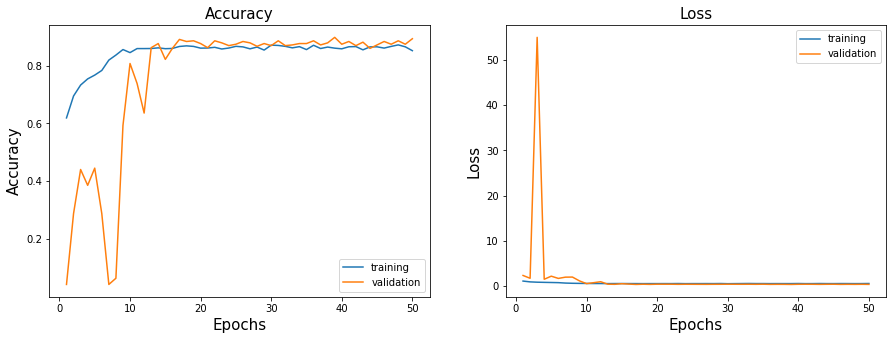

In [14]:
train_val_plot(
    results.history['categorical_accuracy'],
    results.history['val_categorical_accuracy'],
    results.history['loss'],
    results.history['val_loss']
)